# Read data

In [1]:
import pandas as pd

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
train1 = pd.read_csv('data/train.csv')
test1 = pd.read_csv('data/test.csv')

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

# EDA


## Define Functions

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm;
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [5]:
def null_count(dataset):
    '''
    해당 데이터셋에 결측치가 있는 feature와 개수 출력
    '''
    return dataset.isnull().sum()[dataset.isnull().sum()!=0]
    
def null_check(feature):
    '''
    해당 feature의 결측치가 각 데이터셋에 얼마나 있는지 확인.
    dataset도 input으로 받아야 할지 고민.
    '''
    print('--', feature, '--')
    print('train :', train[feature].isnull().sum())
    print('test :', test[feature].isnull().sum())

def val_list(dataset, feature):
    '''
    해당 dataset의 feature가 가진 value들 중복 없이 리스트로 출력
    '''
    return list(set(dataset[feature].values.tolist()))
# val_list = set(train['MSZoning'].values.tolist()) - 중복 없이 value종류 추출 
# 근데 이건 순서가 내 맘대로 안됨

def val_count(feature):
    '''
    train, test 데이터의 value_count를 같이 출력
    input에 데이터셋도 받는게 좋을지..?
    '''
    print('-----', feature, '-----')
    print('---- train ----')
    print(train[feature].value_counts())
    print('---- test ----')
    print(test[feature].value_counts(),'\n')

def map_order(dataset, feature, val_list):
    '''
    Value들을 0부터 순서대로 매핑
    데이터셋(train/test), feature명, 원하는 순서대로 value_list 입력
    '''
    mapping = dict(zip(val_list, range(len(val_list))))
    return dataset[feature].map(mapping) #원하는 순서대로 0부터 매핑된 컬럼 출력


def val_cat(dataset, feature):
    '''
    dataset, feature를 입력받아서 해당 feature에 대해 categorize
    '''
    val_list = set(dataset[feature].values.tolist())
    for feat in val_list:
        dataset[feat] = (dataset[feature]==feat).astype(int)
    dataset = dataset.drop(feature, axis = 1)
    
def avg_price(feature):
    '''
    train set 내의 해당 feature의 value들에 따른 가격의 평균
    '''
    for feat in set(train[feature].values.tolist()):
        mean_price = train['SalePrice'][train[feature] == feat].mean()
        print(feat, ':', mean_price)
        
def price_plot(feature):
    '''
    train set 내의 해당 feature의 value에 따른 가격의 평균 plot 그래프로 출력
    '''
    train.groupby(feature).mean()['SalePrice'].plot()
    
def brief():
    '''
    feature의 분류를 브리핑
    '''
    print('그대로 넣을 거 {}개: \n'.format(len(feature_raw)),feature_raw,'\n')
    print('모아놓고 그대로 넣을지? one-hot을 할지 등 {}개: \n'.format(len(feature_dis)),feature_dis,'\n')
    print('매핑 할 데이터 {}개: \n'.format(len(feature_map)),feature_map,'\n')
    print('one-hot encoding 시킬 것 {}개: \n'.format(len(feature_onehot)),feature_onehot,'\n')
    print('따로 봐야 할 것 {}개: \n'.format(len(feature_extra)),feature_extra,'\n')
    print('삭제할 것 {}개: \n'.format(len(feature_del)),feature_del,'\n')
    
def price_cor(feature):
    '''
    feature와 집값 사이의 상관계수를 프린트하고 반환
    '''
    print(round(float(pd.DataFrame(train.corr()['SalePrice']).loc[feature]),3))
    return round(float(pd.DataFrame(train.corr()['SalePrice']).loc[feature]),3)

def onehot(df, columns_list):
    '''
    columns_list에 있는 df의 column에 대하여 onehot인코딩하여 df을 반환
    '''
    import pandas as pd
    len_list=len(columns_list)
    for i in range(len_list):
        len_cat=len(df.groupby(columns_list[i]))
        catrzed=pd.get_dummies(df[columns_list[i]])
        cat_list=[]
        for j in range(len_cat):
            cat_list.append(df.groupby(columns_list[i]).count().index[j])
        df[cat_list]=catrzed
        df=df.drop([columns_list[i]], axis=1)
    return df

def vif(feature_list):
    '''
    input : ['feat1', 'feat2'] 형식으로 입력
    feature들 간의 vif 계산해서 출력.    
    '''
    X = train[feature_list].dropna()
    df_vif = pd.DataFrame()
    df_vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    df_vif["features"] = X.columns 
    return df_vif

## Feature Classification

- feature들을 하나씩 보면서 5가지 분류로 나눌 계획.  
- 각 분류별로 리스트에 feature이름 저장.  
  
  
- <span class="mark">feature_raw</span> : 그대로 넣을거   
     - 넓이, 길이 등 연속적인 숫자 데이터
- <span class="mark">feature_dis</span> : 모아놓고 그대로 넣을지? one-hot을 할지 등
     - 개수, 유무(0/1) 등 discrete 한 숫자 데이터
- <span class="mark">feature_map</span> : 매핑 할 데이터   
    - 경사도고 낮음 -> 높음 처럼 문자이지만 순서가 있어보이는 경우 숫자로 매핑
- <span class="mark">feature_onehot</span> : one-hot encoding 시킬 것
    - 각각의 특성이 독립?이라서 컬럼을 새로 만들어 주는게 좋아 보이는 경우
- <span class="mark">feature_extra</span> : 따로 봐야 할 것  
    - 그래프를 그려본다거나, 가격과의 관계를 직접 보고 판단
- <span class="mark">feature_del</span> : 삭제
    - 필요 없다고 판단되어 삭제 할 데이터
    

In [6]:
feature_raw = []
feature_dis = []
feature_map = []
feature_onehot = []
feature_extra = []
feature_del = []

## Feature Analysis

### ID

#### 의견

그냥 아이디임.
삭제해도 될 듯.
- 동의

#### 데이터 확인

In [7]:
train['Id'].head()

0    1
1    2
2    3
3    4
4    5
Name: Id, dtype: int64

#### 분류

In [8]:
feature_del.append('Id')

### MSSubClass

- The building class  
- 빌딩의 클래스?  

#### 의견
- discrete한 값임
- 숫자가 크다고 좋은게 아니라서. 다른 방법이 필요함.

#### 데이터 확인
- 숫자가 크다고 무조건 좋지 않음 (ex 180)
- 그래프 그려볼것

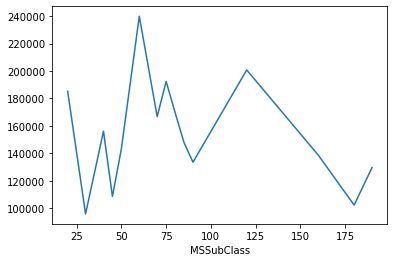

In [9]:
price_plot('MSSubClass')

#### 결측치 확인
- 결측치 없음

#### 분류
- 숫자가 크다고 가격이 커지는게 아니므로 one-hot

In [10]:
feature_onehot.append('MSSubClass')

### MSZoning

- The general zoning classification  
- 주거구역 / 상업구역 등 집이 위치한 구역?을 나타냄.

#### 의견

- C, FV 생각하면 one-hot encoding 하고 싶음.
- 근데 RL, RM, RH간에는 순서?가 있어 보여서..  
- 일단 매핑 해보자 1~5

- 집값 평균 그래프 그려보니 5번이 젤 높고 4번이 젤 낮다
- 순서 조정 필요할듯, 또는 원핫이코딩이 나을 수도.

#### 데이터 확인
- RL -> RM -> RH 순으로 인구 밀집도가 높음.(얘네가 데이터의 대부분임)  
- 나머지 FV(물에 떠있는 집;;), C(상업지구)는 어떻게 처리할지..  

In [11]:
val_count('MSZoning')

----- MSZoning -----
---- train ----
RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64
---- test ----
RL         1114
RM          242
FV           74
C (all)      15
RH           10
Name: MSZoning, dtype: int64 



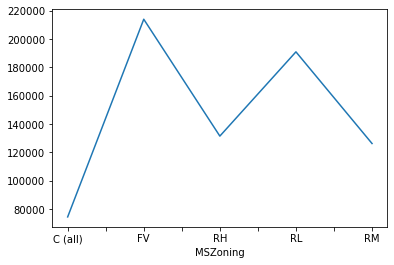

In [12]:
price_plot('MSZoning')

#### 결측치 확인
- test셋에 결측치 4개.
- 데이터를 보면 RL이 압도적으로 많으니까.. RL로 결측 채워보자

In [13]:
null_check('MSZoning')

-- MSZoning --
train : 0
test : 4


In [14]:
test['MSZoning'].fillna('RL', inplace=True)
null_check('MSZoning')

-- MSZoning --
train : 0
test : 0


#### 매핑
- C, FV 생각하면 <span class="mark">카테고라이즈</span> 하고 싶은데 근데 RL, RM, RH간에는 순서?가 있어 보여서..  
->일단 RL -> RM -> RH -> C -> FV 순으로 숫자로 매핑해보기로(0~4)
- 그냥 one-hot 하기! C 제외.

In [15]:
# RL -> RM -> RH -> C -> FV 
#map_MSZoning = {'RL':1, 'RM':2, 'RH':3, 'C (all)':4, 'FV':5}
#train['MSZoning'] = train['MSZoning'].map(map_MSZoning)
#test['MSZoning'] = test['MSZoning'].map(map_MSZoning)

#### 분류
- C 제외하고 one-hot

In [16]:
feature_onehot.append('MSZoning')
#feature_del.append('MSZoning_C (all)')

### *LotFrontage / LotArea

- LotFrontage : Linear feet of street connected to property
- LotArea : Lot size in square feet

#### 의견

- 둘 다 길이, 넓이로 숫자 데이터라서 그냥 넣을 것.
- <span class="mark">값이 큰데 어떻게 normalize할지?</span>
- <span class="mark">길이가 길면, 면적도 넓어질텐데 둘을 하나로 합칠 수 있나?</span>

#### 데이터 확인

In [17]:
#val_count('LotFrontage')

In [18]:
#val_count('LotArea')

In [19]:
#train.plot(x='LotFrontage',y='SalePrice',kind='scatter')

In [20]:
#train.plot(x='LotFrontage',y='SalePrice',kind='scatter',xlim=(0,250))

In [21]:
#train.plot(x='LotArea',y='SalePrice',kind='scatter')

In [22]:
#train.plot(x='LotArea',y='SalePrice',kind='scatter', xlim=(0,50000))

#### 결측치 확인
- LotFrontage에 결측치가 꽤 많음
- 넓이에 따라서 (넓으면 길이도 길게) 넣어주면 좋을거같음

- LotFrontage의 산점도를 보면 이상값이 있음
- 이상값을 제외하고 그래프를 그려보기 위해 x값 범위 설정했더니 양의 상관관계가 있는 듯 하지만 강하지 않음.
- LotFrontage와 LotArea의 산점도 분포가 매우 유사하다.
- 이상값을 어떻게 처리해야 하나?

In [23]:
null_check('LotFrontage'), null_check('LotArea')

-- LotFrontage --
train : 259
test : 227
-- LotArea --
train : 0
test : 0


(None, None)

- 길이 / 넓이 의 비율을 평균내서, 이 비율을 넓이에 곱해줘서 결측치를 채워줄거임.
- 다행히도 넓이는 결측이 없어서 ㅎㅎ (다행히?다행이?)

In [24]:
#Lot_ratio : train/test 데이터의 비율을 다 구해서 평균
#Lot_ratio = ((train['LotFrontage']/train['LotArea']).mean() + (test['LotFrontage']/test['LotArea']).mean())/2
#train['LotFrontage'].fillna(train['LotArea']*Lot_ratio, inplace=True)
#test['LotFrontage'].fillna(test['LotArea']*Lot_ratio, inplace=True) 

In [25]:
null_check('LotFrontage')

-- LotFrontage --
train : 259
test : 227


#### 분류
- LotFrontage를 일단 제외 / LotArea만 넣기
- Normalize에 대한 고민.

In [26]:
feature_del.append('LotFrontage')
feature_raw.append('LotArea')

### Street / Alley

- 거리, 골목의 유형?

#### 의견

- Street는 Gravl, Pave를 categorize
- Alley는 NA 까지 3개로 categorize?
- <span class="mark">그냥 0/1/2를 쓰면 안되는지?</span>

- Street는 Gravel 6개밖에 안되서 무의미한 feature 아닌가?
- Alley는 pave가 Gravel보다 좋아 보이긴 하다. 그러나 전체 데이터의 90%이상을 차지하는 NA가 Gravel보다 좋은 것 같인 한데 pave와는 우열을 가릴 수 없다.
- 그냥 NA가 중간이라 치고 0,1,2 넣는 게 나으려나

#### 데이터 확인
- Gravel / Pave / NA(골목이 없음)

In [27]:
#val_count('Street')
#val_count('Alley')

In [28]:
#train.boxplot(column=['SalePrice'],by='Alley')

In [29]:
# NA값만 분포 확인
#train[train['Alley']=='NA'].plot(y='SalePrice',kind='hist')

#### 결측치 확인

- Alley에 골목이 없는 경우 null 값이 들어가 있는데, 'NA'로 채워주기

In [30]:
#null_check('Street'), null_check('Alley')

In [31]:
#train['Alley'].fillna('NA', inplace=True)
#test['Alley'].fillna('NA', inplace=True)

In [32]:
null_check('Alley')

-- Alley --
train : 1369
test : 1352


#### 분류
- feature_onehot에 추가, 한꺼번에 one-hot encoding
- Street는 제거. 

In [33]:
feature_onehot.append('Street')
feature_onehot.append('Alley')

### LotShape

- General shape of property

#### 의견

- Reg -> IR3 순으로 1,2,3,4 으로 매핑

#### 데이터 확인

- Regular부터, IR의 숫자가 커질수록 안좋은거.
- 문자 그대로 의미는 그럴 것 같은데 평균은 3과 4가 뒤집어져있네 왜일까...
- 표본이 적어서 그런듯... 4가 10개밖에 없어서 평균이 왜곡됐나보당...
- 4는 지워야 하나?

In [34]:
#val_count('LotShape')

In [35]:
#price_plot('LotShape')

In [36]:
#train.boxplot(column=['SalePrice'],by='LotShape')

#### 결측치 확인
- 없음

#### 매핑
- Reg -> IR3 을 1->4 순으로 매핑

In [37]:
# map_LotShape = {'Reg':1, 'IR1':2, 'IR2':3, 'IR3':4}
# train['LotShape'] = train['LotShape'].map(map_LotShape)
# test['LotShape'] = test['LotShape'].map(map_LotShape)

In [38]:
# val_count('LotShape')

#### 분류
- IR3 지우고 one-hot

In [39]:
feature_onehot.append('LotShape')
#feature_del.append('LotShape_IR3')

### LandContour

- Flatness of the property
- 경사도 : 얼마나 평평한지?

#### 의견

- 경사가 낮음 -> 높음 순으로 매핑
- Lv1 -> Low -> HLS -> Bnk 순으로 매핑
- <span class="mark">여기도 0이 너무 많은데..</span>
- 의외로 Hillside가 젤 높고 Bank가 제일 낮네. 데이터가 너무 적어서 왜곡이 있는 건지.. 아님 막 베버리 힐즈? 처럼 적당한 언덕이 부자동네인 건지... 우리나라에도 평창동? 이런데가 약간 산간 인데 고급주택가잖어.. 뭔가 도시를 내려다 볼 수 있어야 비싼 건가? 그렇지만 레알 절벽인 곳은 집값 최하인 거고?

#### 데이터 확인
- Lvl : 거의 평지 / Near Flat/Level 
- Bnk : 경사가 가장 심하다고 봐야하나? / Bank - Quick and Significant rise
- HLS : 경사가 꽤 있음 / Hillside - Significant slope
- Low : 경사가 낮음 / Depression

In [40]:
#val_count('LandContour')

In [41]:
#price_plot('LandContour')

#### 결측치 확인
- 없음

#### 매핑

In [42]:
# map_LandContour = {'Lvl':1, 'Low':2, 'HLS':3, 'Bnk':4}
# train['LandContour'] = train['LandContour'].map(map_LandContour)
# test['LandContour'] = test['LandContour'].map(map_LandContour)

In [43]:
# val_count('LandContour')

#### 분류
- 확실한 순서가 보이지 않아서 one-hot

In [44]:
feature_onehot.append('LandContour')

### Utilities

#### 의견

train set에서 1개 빼고 모두 AllPub이고  
test set에도 결측 2개 제외하고는 모두 AllPub.  
-> 제거해도 될지도?

- 동의. 1개는 의미 없는 듯.

#### 데이터 확인 / 결측치 확인

- AllPub : 다 있음
- NoSewr : 전기, 가스, 물
- NoSeWa : 전기, 가스
- ELO : 전기만 있음

In [45]:
#val_count('Utilities')

#### 분류
- 컬럼을 지워버릴거니까 feature_del에 추가.

In [46]:
feature_del.append('Utilities')

### *LotConfig

- Lot Configuration
- Lot(마당/마당+집?)의 구성

#### 의견

- 일단 one-hot encoding
- 그래프 그려보기?
- FR3는 표본이 너무 적은 거 같고. 나머지는 CulDSac말고는 다 비슷한듯?
- CulDSac과 그 외를 0과 1로만 구분하는 것은 어떨런지?

#### 데이터 확인
- 대부분 inside

In [47]:
#val_count('LotConfig')

- 그래프 그려보기

In [48]:
#avg_price('LotConfig')

In [49]:
#price_plot('LotConfig')

#### 분류

- FR3 제외하고 onehot

In [50]:
feature_onehot.append('LotConfig')
#feature_del.append('LotConfig_FR3')

### LandSlope

- 경사도
- Gentle -> Moderate -> Severe

#### 의견

- 위에 LandContour랑 차이가 뭔지? / 합치거나 할 수 있을지?
- 일단 경사도 순으로 매핑
- 여기도 LandContour랑 비슷한 맥락이네. 경사도가 클수록 비싼듯? Sev가 13개 뿐이어서 엄청 유의미하진 않은 거 같지만.

#### 데이터 확인

- 대부분 다 젠틀하다고 나옴.

In [51]:
#val_count('LandSlope')

In [52]:
#price_plot('LandSlope')

#### 결측치 확인
- 없음

In [53]:
#null_check('LandSlope')

#### 매핑
- Gtl -> Mod -> Sev 순으로

In [54]:
# map_LandSlope = {'Gtl':1, 'Mod':2, 'Sev':3}
# train['LandSlope'] = train['LandSlope'].map(map_LandSlope)
# test['LandSlope'] = test['LandSlope'].map(map_LandSlope)

In [55]:
# val_count('LandSlope')

#### 분류
- Sev 제외 one-hot

In [56]:
feature_onehot.append('LandSlope')
#feature_del.append('LandSlope_Sev')

### !!! Neighborhood

- 도시 경계? 어디랑 인접해있는지?

#### 의견

- 모르겠다 근데 one-hot을 하기에도 종류가 너무 많은거 아닌가?
- 원핫 하기엔 너무 많긴 하다. 아예 그룹바이 평균 집값을 넣어버리는 건 해괴한 짓인가?

#### 데이터 확인

그래프 그려보기

In [57]:
#val_count('Neighborhood')

In [58]:
#avg_price('Neighborhood')

In [59]:
#Nei=pd.DataFrame(train.groupby('Neighborhood').mean()['SalePrice']).sort_values(by=['SalePrice'])
#Nei.plot()

#### 분류
- 그냥 one-hot을 해버리기에 값들이 너무 다양한데, 고민해보기

In [60]:
feature_extra.append('Neighborhood')

### !!! Condition1/2

- Condition
- 그린벨트여부, 주변에 철도 여부 등등

#### 의견

- 1과 2를 합치는건 좋아 보이는데.
- 근데 단순 컨디션 갯수로 판단하는게 괜찮을까?
- one-hot을 해도 적합할까?
- 같은 값들로 이루어진 열들이라 원핫으로 처리해도 괜찮을듯.
- Condition1,2를 다 해도 값이 10개 미만인 RRNe, RRNn, PosA는 제거하고 원핫 돌리는 건 어떤지.
- 둘이 합쳐서 하되, Norm은 기본값인 거 같으니 0으로 처리하고 나머지 해당하는 값에 1 체크하면 될듯

#### 데이터 확인

- 대부분 노말임.

In [61]:
# val_count('Condition1')

In [62]:
# val_count('Condition2')

- norm보다 싼거도 있네  
- 옵션이 있다고 무조건 좋은게 아닌가봄..  
- 그러면 컨디션 개수로 묶는건 진짜 아닌거같은뎅..
- Condition2의 데이터가 너무 적어서 왜곡이 생긴 걸 수도...
- Condition1으로 체크해보니 더 완곡해졌어

In [63]:
# avg_price('Condition2')

In [64]:
# price_plot('Condition2')
# price_plot('Condition1')
# 노란 선이 Condition1

In [65]:
# 컨디션 2가 Norm이 아닌데, 컨디션 1이 Norm인 경우는 없음.
# train['Condition1'][train['Condition2']!='Norm']

#### 분류
- Cond2는 거의 다 Norm이라...
- PosA, RRNn, RRNe 제외하고 원핫

In [66]:
# feature_extra.append('Condition1')
# feature_extra.append('Condition2')
feature_onehot.append('Condition1')
feature_del.append('Condition2')
# feature_del.extend(['Condition1_PosA', 'Condition1_PRNn', 'Condition1_PRNe'])

### BldgType

- 주거 형태 
- 1Fam : 독채
- 2FmCon : 독채에 두 가구 거주
- Duplx : Duplex(이중?)
- TwnhsE : Townhouse End unit
- Twnhs(I) : Townhouse Inside unit
    - 설명 문서엔 TwnhsI 였는데 실제 값은 Twnhs 가 들어가있음

#### 의견

- 2fmCon < Duplex <= Twnhs <<<< TwnhsE <= 1Fam
- 근데 순서가 약간 애매함. 생각했던거랑 실제 가격이랑
- 애매하니까 one-hot 가자
- 동의

#### 데이터 확인

In [67]:
# val_count('BldgType')

In [68]:
# price_plot('BldgType')

#### 분류

In [69]:
feature_onehot.append('BldgType')

### HouseStyle

- 주거 스타일

#### 의견

- one-hot 하자
- 동의

#### 데이터 확인

In [70]:
# val_count('HouseStyle')

In [71]:
# avg_price('HouseStyle')

In [72]:
# price_plot('HouseStyle')

#### 분류

In [73]:
feature_onehot.append('HouseStyle')

### ! OverallQual / OverallCond

- 전체적인 퀄리티, 컨디션을 평가한 지표

#### 의견

- 그냥 숫자라서 그대로 넣으면 될 듯하긴 함
- 상관계수가 엄청 높음.
- 퀄리티는 상관계수가 높은데 컨디션은 상관계수가 낮음
- 컨디션은 5일때 집값 평균이 젤 높은듯?

#### 데이터 확인

In [74]:
# val_count('OverallQual'), val_count('OverallCond')

In [75]:
# train.boxplot(column='SalePrice', by='OverallCond')

#### 분류
- discrete한 값이니까

In [76]:
feature_dis.append('OverallQual')
feature_dis.append('OverallCond')

### YearBuilt / YearRemodAdd

- 지어진 년도 / 리모델링한 년도

#### 의견

- 같은 년도에 공사를 했어도, 새 건물이 리모델링한 건물보다 좋겠지?
- 일단 각각 넣고 두 feature를 합칠 방법이 있을지?
- normalize : 1872를 빼주자
- 산점도를 보면 양의 상관관계가 있어보임
- 상관관계 둘다 0.5가 넘네
- YearRemodAdd에도 왜 똑같이 1872를 빼준 거얌??
- YearRemodAdd과 집값의 산점도를 보면 YearRemodAdd의 최솟값에 데이터가 몰려있음... 1950년 이전이면 다 1950으로 들어간듯 이거 어떻게 처리하지?

#### 데이터 확인

In [77]:
# 가장 오래전에 지어진 건물의 년도 출력
# min(val_list(train, 'YearBuilt')[0], val_list(test, 'YearBuilt')[0])

In [78]:
# min(train['YearRemodAdd'])

In [79]:
# train.plot(x='YearBuilt',y='SalePrice', kind='scatter')

In [80]:
# train.plot(x='YearRemodAdd',y='SalePrice', kind='scatter')

#### 분류
- 뒤에 있을 팔린 년도와 함께 따로 계산

In [81]:
feature_extra.append('YearBuilt')
feature_extra.append('YearRemodAdd')

### RoofStyle / RoofMatl

- 지붕 스타일, 재질

#### 의견

- one-hot.
- 근데 특정 값만 엄청 많은데 one-hot을 하면 0에 가까운 열들이 생기는 문제?
- 너무 적은 값들은 제거해도 될듯!
- RoofMatl은 아예 feature를 제거해도 될듯!
- 그래프 그려보기ㅣ

#### 데이터 확인

거의 다 Gable / CompShg 임.

In [82]:
# val_count('RoofStyle'), val_count('RoofMatl')

#### 분류
- RoofMatl은 아예 제거
- RoofStyle은 Gambrel, Flat, Mansard, Shed 제외 one-hot

In [83]:
feature_onehot.append('RoofStyle')
feature_del.append('RoofMatl')
# feature_del.extend(['RoofStyle_Gambrel', 'RoofStyle_Flat', 
#                    'RoofStyle_Mansard', 'RoofStyle_Shed'])

### Exterior1st / Exterior2nd

- 집 외부를 뭐로 덮고 있는지?

#### 의견

- one-hot으로 보내고 싶긴한데
- 값이 1개인 친구들도 one-hot을 하는게 맞나?
- 값이 1개인 친구들은 제거해도 될듯
- 이게 feature 목록이 train과 test가 일치해야하니까... 값이 적은 것들은 제거하는 게 전처리 속도도 많이 개선시킬듯
- 그리고 이거도 합칠 수 있을듯.
- conditioni1/2랑 다르게 얘네는 독립?인 거 같어 1st하고 2nd가 포함관계에 있지 않음. VinySd를 체크해보니 1st하고 2nd 둘다 VinySd인 집은 502개임 2개는 2nd만 VinySd이고 13개는 1st만 VinySd임

#### 데이터 확인

In [84]:
# val_count('Exterior1st'), val_count('Exterior2nd')

In [85]:
# train[train['Exterior1st']=='VinylSd'].loc[train['Exterior2nd']=='VinylSd']

In [86]:
# price_plot('Exterior1st')
# price_plot('Exterior2nd')
# 노란색이 2nd

In [87]:
# null_check('Exterior1st'), null_check('Exterior2nd')

In [88]:
#test['Exterior1st'].fillna('VinylSd', inplace=True)
#test['Exterior2nd'].fillna('VinylSd', inplace=True)

#### 분류
- 원핫 할건데 신경 좀 써줘야할듯

In [89]:
feature_extra.append('Exterior1st')
feature_extra.append('Exterior2nd')

### MasVnrType

- 벽돌 베니어 벽의 타입..?

#### 의견

- one-hot
- None을 제외하고 3개의 값으로 원핫 하면 되지 않나? 어차피 구분이 되니까 근데 그렇게 생각하니 그럼 모든 원핫은 값을 1개 빼고 해도 되는 거 아닌가 싶은 생각도 드네.. 그렇게 하면 성별은 걍 남0여1 이런 식으로 처리하는 것과 같은데.. 걍 None도 넣고 하는 게 더 결과가 좋으려나

#### 데이터 확인

In [90]:
# val_count('MasVnrType')

In [91]:
# price_plot('MasVnrType')

In [92]:
# null_check('MasVnrType')

In [93]:
#train['MasVnrType'].fillna('None', inplace=True)
#test['MasVnrType'].fillna('None', inplace=True)

In [94]:
# null_check('MasVnrType')

#### 분류

In [95]:
feature_onehot.append('MasVnrType')
# feature_del.append('MasVnrType_BrkCmn')

### MasVnrArea

- 베니어 벽의 넓이?
- 0만 어떻게 처리하면 될듯
- 상관관계도 큰 편

#### 의견

- 넓이 값. 그대로 넣고 normalize 고민
- 대부분 0임. 위에 타입이 None이 가장 많아서 그런듯

#### 데이터 확인

In [96]:
# val_count('MasVnrArea')

In [97]:
# train.plot(x='MasVnrArea',y='SalePrice',kind='scatter')

In [98]:
# null_check('MasVnrArea')

#### 분류

In [99]:
feature_raw.append('MasVnrArea')

### ExterQual / ExterCond

- 

#### 의견

- 대부분 TA(Typical/Average)
- 그래도 순서가 있는거니까 숫자로 매핑해봄.
- ExterQual은 예상대로인데 아까처럼 컨디션은 순서대로가 아니네.. 5번이 낮게 나오면 값이 3개밖에 없어서 그런갑다 할텐데 4번은 그렇지도 않은데...
- 상관계수도 아까처럼 퀄리티는 높은데 컨디션은 무시해도 되는 수준.

#### 데이터 확인

In [100]:
#val_count('ExterQual')
# val_count('ExterCond')

In [101]:
# price_plot('ExterQual')

In [102]:
# price_plot('ExterCond')

#### 결측치 확인
- 없음!

In [103]:
# price_cor('ExterCond')

In [104]:
# price_cor('ExterQual')

#### 분류
- Qual은 매핑
- Cond는 순서가 잘 안보여서 원핫 (Ex, Po 제외)

In [105]:
feature_map.append('ExterQual')
feature_onehot.append('ExterCond')
# feature_del.extend(['ExterCond_Ex', 'ExterCond_Po'])

### Foundation

- 대문 종류

#### 의견

- one-hot / 3번밖에 안나오는 값에 대한 고민? 제거
- 원핫 하면 될듯

#### 데이터 확인

In [106]:
# val_count('Foundation')

In [107]:
# price_plot('Foundation')

#### 결측치 확인
- 없음!

#### 분류
- Stone, Wood 제외 원핫

In [108]:
feature_onehot.append('Foundation')
# feature_del.extend(['Foundation_Stone', 'Foundation_Wood'])

### BsmtQual / BsmtCond

- 

#### 의견

- Po -> EX 순이긴 한데. No basement는?
- No basement 는 0으로 해서 매핑해보기.
- 여기는 앞의 퀄리티/컨디션 조합들과 다르게 컨디션이 유의미한 편

#### 데이터 확인

In [109]:
# val_count('BsmtQual')

In [110]:
# price_plot('BsmtQual')

In [111]:
# price_plot('BsmtCond')

#### 결측치 확인
- NA로 채워주긴 할건데, Basement가 없어서가 아니라 진짜 결측인 애들이 몇개 있음(2~3개)
- 일단 NA로 채우기

In [112]:
# null_check('BsmtQual'), null_check('BsmtCond')

#### 매핑
- NA(0), Po(1), Fa(2), TA(3), Gd(4), Ex(5)

#### 분류

In [113]:
feature_map.append('BsmtQual')
feature_map.append('BsmtCond')

### BsmtExposure

- 

#### 의견

- No basement가 결측치로 처리되어 있어서 'NA'로 바꿔준 다음 one-hot encoding
- 얘네도 뚜렷하게 순서가 있는 거 같기도 한데! 지하실이 없으면 젤 싸고 있는 애들 중에 햇빛이 잘 들수록 비싸지는뎅! 그렇게 01234해서 상관계수 계산하면 0.5 나오긴 하넹!
- 매핑하고 나서 선그래프도 너무너무 직선인뎅??? 뭐야 오류인가

#### 데이터 확인

In [114]:
# val_count('BsmtExposure')

In [115]:
#price_plot('BsmtExposure')

#### 결측치 확인
- basement가 없는 경우 결측으로 처리되어 있어서, 'NA' 넣어주기

In [116]:
# null_check('BsmtExposure')

#### 매핑

#### 분류
- one-hot

In [117]:
# feature_onehot.append('BsmtExposure')
feature_map.append('BsmtExposure')

### ***BsmtFinType / SF

- basement type1, type2, Unfinished를 합치면 총 면적.

In [118]:
Bsmt = ['BsmtFinType1', 'BsmtFinType2',
        'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF']

#### 의견

- No basement가 많은데.. 
- type1, type2, unf 를 각각 쓸지 / Total로 합쳐서 쓸지?
- total 쓰면 될듯! 상관계수도 높고 각자 쓰자니 0을 처리하기도 어렵고 type2는 상관계수가 거의 0인데 그것만 없애는 것도 그렇고...
- type2의 종류도 보니까 Unf가 1256개나 되네. 그래서 넓이도 0이 많은갑다
- type1,2의 종류도 Exterior 1st,2nd 처리방법과 같게 하면 될듯 어케 해야할지는 아직 모르겠지만..

#### 데이터 확인

In [119]:
# val_count('BsmtFinType2')

In [120]:
# train.loc[:,'BsmtFinType1':'TotalBsmtSF']

In [121]:
# train.plot(x='BsmtFinSF1',y='SalePrice',kind='scatter')
# train.plot(x='BsmtFinSF2',y='SalePrice',kind='scatter')
# train.plot(x='BsmtUnfSF',y='SalePrice',kind='scatter')
# train.plot(x='TotalBsmtSF',y='SalePrice',kind='scatter')
# price_cor('BsmtFinSF1')
# price_cor('BsmtFinSF2')
# price_cor('BsmtUnfSF')
# price_cor('TotalBsmtSF')

In [122]:
# price_plot('BsmtFinType1')
# price_plot('BsmtFinType2')
# 노란색이 타입2

#### 결측치 확인

#### 분류
- 토탈만 사용해보기

In [123]:
feature_del.extend(['BsmtFinType1', 'BsmtFinType2', 'BsmtFinSF1',
                    'BsmtFinSF2', 'BsmtUnfSF'])

feature_raw.append('TotalBsmtSF')

### Heating / HeatingQC

- 난방의 종류와 퀄리티

#### 의견

- 난방의 종류가 무엇이든 QC에 포함이 되는게 아닌지..?
- 난방 종류는 one-hot, QC는 점수로 매핑
- QC 매핑은 좋은 거 같음.
- 종류는 1428개가 GasA라서 굳이 원핫 할 만큼 좋은 feature는 아닌듯? 제거 제안

#### 데이터 확인

In [124]:
# train['HeatingQC'].value_counts()

In [125]:
# price_plot('HeatingQC')

In [126]:
# train['Heating'].value_counts()

#### 결측치 확인
- 없음

#### 매핑

#### 분류

In [127]:
# feature_onehot.append('Heating')
feature_del.append('Heating')
feature_map.append('HeatingQC')

### CentralAir / Electrical

- 

#### 의견

- CentralAir는 Y/N을 1/0으로 매핑
- 동의
- Electrical은 one-hot
- FuseP랑 mix는 제거해도?

#### 데이터 확인

In [128]:
# val_count('Electrical')

In [129]:
# val_count('CentralAir')

#### 결측치 확인
- 최빈값인 'SBrkr'로 결측치 채움

In [130]:
# null_check('CentralAir'), null_check('Electrical')

#### 매핑
- CentralAir의 Y/N을 1/0으로

#### 분류
- FuseP, Mix 제외

In [131]:
feature_map.append('CentralAir')
feature_onehot.append('Electrical')
# feature_del.extend(['Electrical_FuseP', 'Electrical_Mix'])

### Floor

- 1stFlrSF / 2ndFlrSF : 1층/2층 Floor의 면적
- 2ndFlrSF는 0인 값이 많긴 한데, 1층집이라는 얘긴데, 분포를  2층집이라고 해서 1층집보다 많이 비싸도 않네. 2층 넓이 0인 행과 아닌 행 1로 해서 집값 박스플랏 그려봄. 큰차이는 없는듯 1,2층면적을 더해도 괜찮나?
- 상관계수는 각각
> - 1stFlrSF	0.605852
> - 2ndFlrSF	0.319334
> - sum	0.716883
> - 더해서 처리해도 되려나.
- LowQualFinSF : 모든 층 통츨어서 마감이 잘 안된 부분?의 면적
- LowQualFinSF은 numeric인데 0이 1434개나 되서 무의미한듯? 걍 제거해도 될듯


In [132]:
# train.plot(x='1stFlrSF',y='SalePrice',kind='scatter')
# train.plot(x='2ndFlrSF',y='SalePrice',kind='scatter')
# SF=pd.read_csv('data/train.csv')
# SF.loc[SF['2ndFlrSF']!=0,['2ndFlrSF']]=1
# SF.boxplot(column='SalePrice',by='2ndFlrSF')
# train.plot(x='LowQualFinSF',y='SalePrice',kind='scatter')

In [133]:
# SF=pd.read_csv('data/train.csv')
# SF['sum']=SF['1stFlrSF']+SF['2ndFlrSF']
# pd.DataFrame(SF.corr()['SalePrice']).loc[['1stFlrSF','2ndFlrSF','sum']]

In [134]:
# val_count('LowQualFinSF')

#### 의견

- 면적데이터라서 normailze하고 그냥 넣으면 될 것 같음.
- 1층과 2층을 합쳐버리는건?

#### 결측치 확인
- 없음!

#### 분류

In [135]:
# for floor in ['1stFlrSF', '2ndFlrSF', 'LowQualFinSF']:
#    feature_raw.append(floor)
# for floor in ['1stFlrSF', '2ndFlrSF']:
#     feature_raw.append(floor)
feature_del.extend(['1stFlrSF', '2ndFlrSF', 'LowQualFinSF'])

### GrLivArea

- 지상 주거 공간의 넓이

#### 의견

- 그냥 넣어주면 될 듯?
- 동의

#### 데이터 확인

In [136]:
# train['GrLivArea'].head()

In [137]:
# train.plot(x='GrLivArea',y='SalePrice',kind='scatter')

In [138]:
# price_cor('GrLivArea')

#### 결측치 확인
- 없음!

#### 분류

In [139]:
feature_raw.append('GrLivArea')

### Bathroom

- 화장실의 개수

#### 의견

- 그래프 그려볼 필요.
- 일단 discrete에 다 넣어놓기
- 값의 count가 한자릿수인 값들은 빼도 될듯?
- 상관계수
> - BsmtFullBath 0.227
> - BsmtHalfBath -0.017
> - FullBath 0.561
> - HalfBath 0.284
- 상관계수가 낮지 않긴 한데, 급 의문이 discrete 데이터와 상관계수를 구하는 게 유의미한가? 위에서도 discrete 데이터에 상관계수 많이 구해봤던 거 같은데 ㅠㅠㅠ 생각해봐야할듯... 낼 해야지... 

#### 데이터 확인

In [140]:
# val_count('BsmtFullBath')
# val_count('BsmtHalfBath')
# val_count('FullBath')
# val_count('HalfBath')

In [141]:
# price_plot('BsmtFullBath') #파랑
# price_plot('BsmtHalfBath') #노랑
# price_plot('FullBath') #빨강
# price_plot('HalfBath') #초록

#### 결측치 확인
- test set의 BsmtFullBath, BsmtHalfBath에 각각 결측 2개씩
- 최빈값 0으로 채움

In [142]:
null_check('BsmtHalfBath')

-- BsmtHalfBath --
train : 0
test : 2


#### 분류

In [143]:
feature_dis.extend(['BsmtFullBath', 'BsmtHalfBath',  'HalfBath'])

### Bedroom, Kitchen, TotalRooms

- 침실, 주방의 개수 및 총 방의 개수

#### 의견

- 일단 다 discrete feature로 분류
- 근데 전체 방 개수에 침실/주방 개수가 포함되는데?
- KitchenQual 은 0->4로 매핑
- 침실이든 주방이는 전체 방이든 많다고 비싸지는 건 아니네... 희한하네...
- 걍 그대로 넣어도 머신러닝 모듈이 비선형 관계를 알아서 분석해서 예측해주나? 모듈마다 다르겠지? 모듈마다 어떻게 다른지를 모르니까 모르겠다...

#### 데이터 확인

In [144]:
# train['TotRmsAbvGrd']-train['BedroomAbvGr']-train['KitchenAbvGr']
#train['KitchenAbvGr'].value_counts()
#val_count('KitchenQual')

In [145]:
# val_count('BedroomAbvGr')

In [146]:
# price_plot('KitchenQual')

In [147]:
# price_plot('BedroomAbvGr')

In [148]:
# price_plot('KitchenAbvGr')

In [149]:
# price_plot('TotRmsAbvGrd')

#### 결측치 확인
- test-set KitchenQual에 결측 하나.
- 최빈값이자 중앙값인 TA로 처리

#### 매핑
- 주방 퀄리티를 숫자로

#### 분류

In [150]:
feature_dis.extend(['BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd'])
feature_map.append('KitchenQual')

### Functional

- 

#### 의견

- one-hot? / extra에 넣어놓고 그래프 그려보기

- Sev, Maj1/2는 제거하고 나머지 원핫?

#### 데이터 확인

In [151]:
# val_count('Functional')

In [152]:
# price_plot('Functional')

In [153]:
# train.boxplot(column=['SalePrice'],by='Functional')

#### 결측치 확인
- 최빈값으로 결측치 채워줌

#### 분류
- Maj1, Maj2, Sev제거 원핫

In [154]:
feature_onehot.append('Functional')
# feature_del.extend(['Functional_Maj1', 'Functional_Maj2', 'Functional_Sev'])

### Fireplaces / Qu

- 벽난로의 개수 및 퀄리티

#### 의견

- 벽난로의 개수는 discrete로.
- Quality는 매핑
- 벽난로가 많아질수록 비싸지긴 하는뎅
- 벽난로 퀄리티가 1점인 집은 벽난로가 없는 집보다 집값 평균은 아주 약간 낮네... 유의미한 차이는 아닌 거 같지만... 집값 평균 차이 자체가 작기도 하고 난로 없는 집이 690개고 난로 퀄리티 1점인 집이 20개기도 해서
- 난로의 퀄리티에 난로가 없는 경우가 들어 있는 게 뭔가 안 맞는 거 같은데... 퀄리티가 0점이라는 게 아니잖엉... 걍 난로가 없다는 건데 그건 난로 퀄리티가 1인 것보다 나은 상황일 수 있음... 이걸 어떻게 전처리해야 할까...

#### 데이터 확인

In [155]:
# val_count('Fireplaces')

In [156]:
# price_plot('Fireplaces')

#### 결측치 확인
- fireplace가 없는 경우 'NA'로 채워주기

#### 매핑

In [157]:
# val_count('FireplaceQu')

In [158]:
# price_plot('FireplaceQu')

#### 분류

In [159]:
feature_dis.append('Fireplaces')
feature_map.append('FireplaceQu')

### ***Garage

- 차고에 관한 항목들

In [160]:
Garage = ['GarageType', 'GarageYrBlt', 'GarageFinish',
'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive']

#### 의견

- one-hot : Type, PavedDrive
- discrete : YrBlt, Cars
- mapping : Finish, Qual, Cond
- raw : Area

#### 데이터 확인

In [161]:
#val_count('GarageCars')

In [162]:
# train.loc[:,'GarageType':'PavedDrive']

#### 결측치 확인
- Type, YrBlt, Finish, Qual, Cond에 차고가 없는 경우 결측이 들어가있음.
- 'NA' 혹은 0으로 데이터 형태에 맞게 채워주기
- Cars/Area의 결측 하나는 0으로

#### 매핑
- Finish 는 NA, Unf, Rfn, Fin 순으로
- Qual, Cond 는 하던대로

In [163]:
# train.loc[:,'GarageType':'PavedDrive'].hist()

- 여기 퀄리티랑 컨디션 히스토그램으로 보니까 더 극적으로 3만 많아보이네 걍 넣고 돌리면 되니까 굳이 피쳐 삭제할 필요는 없게찌??
- 여기서도 컨디션은 집값과 선형관계가 아니긴한데
- 머신러닝 모듈이 비선형관계도 모델링 해주는가?
- 아니라면 비선형 변수는 어떻게 처리해야 하는가?

In [164]:
# train['GarageQual'].hist()

In [165]:
# price_plot('GarageQual')

In [166]:
# train['GarageCond'].hist()

In [167]:
# val_count('GarageQual')

In [168]:
# val_count('GarageCond')

In [169]:
# price_plot('GarageCond')

GarageType은 원핫 동의

In [170]:
# val_count('GarageType')

In [171]:
# price_plot('GarageType')

PavedDrive는 순서가 뚜렷한 거 같은뎅 012로 넣으면 어떨지
- 비포장 -> 일부 포장 -> 전체 포장 순

In [172]:
# val_count('PavedDrive')

In [173]:
# price_plot('PavedDrive')

GarageArea는 raw 동의

In [174]:
# train.plot(x='GarageArea',y='SalePrice',kind='scatter')

In [175]:
# price_cor('GarageArea')

In [176]:
# val_count('GarageFinish')

In [177]:
# price_plot('GarageFinish')

GarageCars는 4가 5개밖에 없어서 4의 평균집값이 왜곡된듯

In [178]:
# price_plot('GarageCars')

In [179]:
# val_count('GarageCars')

In [180]:
# price_plot('GarageYrBlt')

#### 분류
- 차고가 지어진 년도는 다른 년도들이랑 같이 보게 extra로

In [181]:
feature_onehot.extend(['GarageType', 'PavedDrive'])
feature_dis.append('GarageCars')
feature_extra.append('GarageYrBlt')
feature_map.extend(['GarageFinish', 'GarageQual', 'GarageCond'])
feature_raw.append('GarageArea')

### Extra Areas

- 실외 부가적인 공간들의 넓이(Deck, Porch)

In [182]:
ex_area = ['WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch']

In [183]:
# train.corr()['WoodDeckSF':'ScreenPorch']['SalePrice']

In [184]:
# train.loc[:,'WoodDeckSF':'ScreenPorch'][500:550]

#### 의견

- 전부 면적 값이므로 그대로 넣기 / normalize 고민
- 그대로 넣기 동의 Scale은 안 해도 될듯? 값이 엄청 크거나 하진 않은 거 같은뎅

#### 결측치 확인
- 없음!

#### 분류

In [185]:
feature_raw.extend(ex_area)

### Pool, Fence, Misc

- 수영장, 펜스, 그 외 추가적인 feature들

#### 의견

- PoolArea랑 QC를 동시에 반영? (곱한다거나)
- 일단 Area는 면적이니까 raw / PoolQC, Fence는 mapping
- Pool은 데이터가 7개밖에 없당... 무의미한 거 같엉 심지어 테스트에도 3개밖에 없음... Pool관련은 다 지우는 게 어떤가.
- MiscFeature의 종류가 중요할까? 가격이 있으니까 지우는걸로..
- 그래프 보면 Misc가격이랑 집값이 상관 없어보임. 상관계수도 -0.02 심지어 음수네...
- MiscFeature는 Shed정도가 그나마 49개라 의미가 있다고 여길 수 있는데 shed 평균 집값을 보면 전체평균보다 15%정도 낮은 거 같음 걍 Misc가 있다 없다 정도만 구분해서 원핫 하던가 아니면 걍 지워버려도 될듯...

- Fence는 원핫

#### 데이터 확인

In [186]:
# val_count('MiscFeature')

In [187]:
# val_count('PoolQC')

In [188]:
# val_count('Fence')

In [189]:
# price_plot('Fence')

#### 결측치 확인
- Pool, Fence가 없는경우 'NA'로 바꿔주기

#### 매핑

In [190]:
# val_count('MiscFeature')

In [191]:
# price_plot('MiscVal')

In [192]:
# price_cor('MiscVal')

In [193]:
# price_plot('MiscFeature')
# train['SalePrice'].mean()

In [194]:
# train.groupby('MiscFeature').mean()

#### 분류

In [195]:
feature_onehot.append('Fence')
feature_del.extend(['MiscFeature', 'PoolArea', 'PoolQC', 'MiscVal'])

### MoSold / YrSold

- 팔린 월/년도

#### 의견

- discrete
- 년도 normalize / 둘을 합쳐야할지 각각 반영해야 할지?
- 미래에 팔릴 집값을 예측하는 거라면 월만 의미 있고 년은 무의미 하겠지만... test의 집값을 맞추는 거라면... test에도 년도 분포가 train가 같으니까 년도도 넣어야 할듯
- 둘이 합칠 수는 없을듯? 의미가 달라서... 시작점을 기준으로 1개월씩 지나는 방식으로 해도 선형관계가 있는 게 아니고 딱 그 해 그 달에 대한 정보가 유의미한 거니까 원핫인코딩을 하던가 해야할듯 그렇게 하면 총 60개월이니까 열이 60개라서... 걍 둘이 따로 두고 그대로 돌리던가 각자 원핫 하던가? 

#### 데이터 확인

In [196]:
# val_count('YrSold')

In [197]:
# val_count('MoSold')

In [198]:
# price_plot('YrSold')

In [199]:
# price_plot('MoSold')

#### 결측치 확인
- 없음!

#### 분류
- 지은 연도랑 같이 연산

In [200]:
feature_extra.extend(['MoSold', 'YrSold'])

### Sale Type / Condition

- 거래 타입 / 조건

#### 의견

- 순서가 있어보이지만, 애매한 부분이 있어서 일단 onehot 하기로
- 이거도 그래프 꼭 그려보기
- 개수 적은 값들 처리하고 원핫하면 될듯

#### 데이터 확인

In [201]:
# val_count('SaleType')

In [202]:
# val_count('SaleCondition')

In [203]:
# price_plot('SaleCondition')

In [204]:
# price_plot('SaleType')

#### 결측치 확인
- test의 SaleType에 결측 한개 -> 최빈값 WD로 채우기

#### 분류
['ConLD', 'ConLI', 'ConLw', 'CWD', 'Oth', 'Con', 'Alloca', 'AdjLand'] 제거

In [205]:
feature_onehot.extend(['SaleType', 'SaleCondition'])
# feature_del.extend(['SaleType_ConLD', 'SaleType_ConLI', 'SaleType_ConLw',
#                     'SaleType_CWD', 'SaleType_Oth', 'SaleType_Con',
#                     'SaleCondition_Alloca', 'SaleCondition_AdjLand'])

# save data

In [206]:
train.to_csv('data/EDA/train_EDA_0916.csv', index = False)
test.to_csv('data/EDA/test_EDA_0916.csv', index = False)

In [207]:
feature_dict = {'raw':feature_raw, 'dis':feature_dis, 
               'map':feature_map, 'onehot':feature_onehot,
                'extra':feature_extra, 'del':feature_del
               }

In [208]:
#features = pd.DataFrame(feature_dict)
features = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in feature_dict.items() ]))
features.to_csv('data/EDA/feat_class_0916.csv', index = False)